<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multi–Armed-Bandit-for-Pricing" data-toc-modified-id="Multi–Armed-Bandit-for-Pricing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multi–Armed Bandit for Pricing</a></span><ul class="toc-item"><li><span><a href="#Demand-modelling" data-toc-modified-id="Demand-modelling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Demand modelling</a></span></li><li><span><a href="#Run-simulations" data-toc-modified-id="Run-simulations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Run simulations</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Multi–Armed Bandit for Pricing

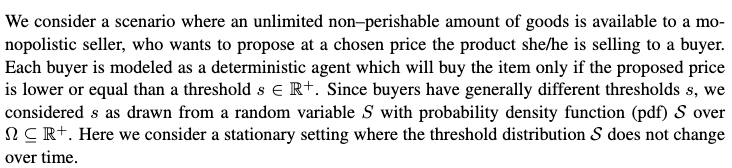

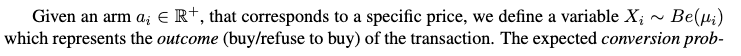
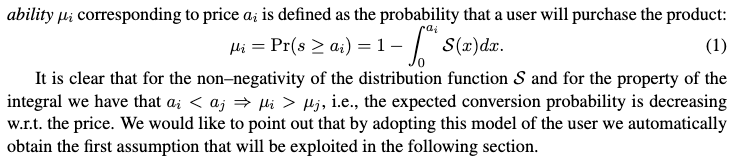

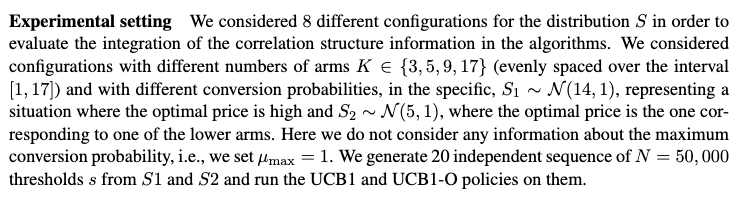

basically:
1. Get pdf of S
2. Each arm has price $a_i$ associated with it.
3. If we pull arm $i$, then we would receive $X_i \sim Be(\mu_i)$, $\mu_i=1-P(s \le a_i)$$

So we can implement it wrapping the `BernoulliBandit`

I can also use **exponential** distribution for better modelling

bernoulli bandit is used below

In [27]:
import itertools

import scipy.stats as ss
from joblib import Parallel, delayed

from bandits.pricing.bandits import PricingBernoulliBanditEnv
from bandits.pricing.agents import UCB1OAgent, SLRAgent

from bandits.bandits import BernoulliBanditEnv
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

### Demand modelling

In [15]:
np.random.seed(2)
N_SIMULATIONS = 10
T = 2000

eps = 1e-2  # probability of exploration
alpha = 1

In [16]:
p_min = 1
p_max = 10
K = 9
dist_mean = 5
dist_std = 2  # note: I increased it to 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

<>:12: DeprecationWarning: invalid escape sequence \s
<>:21: DeprecationWarning: invalid escape sequence \m


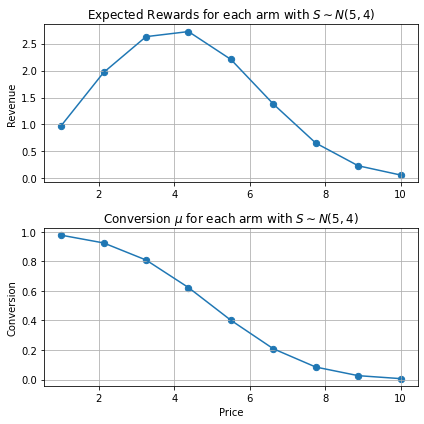

In [17]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

### Run simulations

In [65]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 10000

eps = 1e-2  # probability of exploration
alpha = 1

In [66]:
p_min = 1
p_max = 10
K = 9
dist_mean = 2
dist_std = 3
dist = ss.norm(loc=dist_mean, scale=dist_std)

<>:12: DeprecationWarning: invalid escape sequence \s
<>:21: DeprecationWarning: invalid escape sequence \m


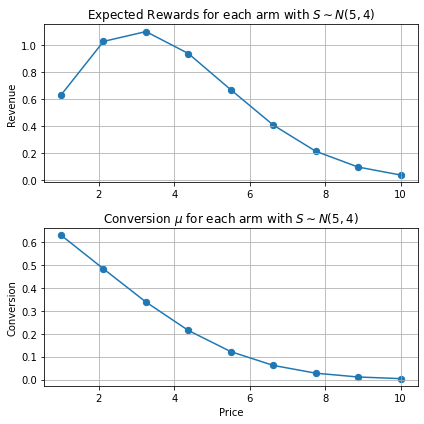

In [67]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

In [68]:
def simulate_agent(T, K, dist, p_min, p_max, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingBernoulliBanditEnv(num_arms=K, dist=dist, p_min=p_min, p_max=p_max)
    # print(env.max_reward)
    # print(env.mus.round(3))
    # print(env.mus * env.action_to_price)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        # print('choosing action')
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        # print('step', observation, reward, done, info)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret

In [106]:
agent_funcs = [
    ("UCB1", lambda env: UCB1Agent(alpha=alpha, num_arms=env.action_space.n, reward_normalization=2*p_max)),
    ("UCB1-O", lambda env: UCB1OAgent(alpha=alpha, action_to_price=env.action_to_price)),
    ("SLRAgent", lambda env: SLRAgent(alpha=alpha, action_to_price=env.action_to_price)),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [107]:
# # just to check if it works
# for n_simulation, agent_tuple in tqdm(combinations):
#     simulate_agent(T, K, dist, p_min, p_max, agent_tuple, n_simulation)
#     break

In [108]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, dist, p_min, p_max, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/150 [00:00<?, ?it/s]

means=array([ 0.43232695,  0.72897773,  0.82475164,  0.71964868,  0.41366886,
       -0.09318783, -0.80092138, -1.7095318 , -2.81901909])
estimated_quantities=array([ 0.43232695,  0.34304834,  0.25376974,  0.16449113,  0.07521252,
       -0.01406609, -0.10334469, -0.1926233 , -0.28190191])
self.arm_to_num_pulls=array([ 5.,  9., 12.,  8.,  4.,  2.,  1.,  1.,  1.])

means=array([ 0.42975828,  0.72455875,  0.81958293,  0.71483082,  0.41030243,
       -0.09400225, -0.79808321, -1.70194045, -2.80557399])
estimated_quantities=array([ 0.42975828,  0.34096882,  0.25217936,  0.1633899 ,  0.07460044,
       -0.01418902, -0.10297848, -0.19176794, -0.2805574 ])
self.arm_to_num_pulls=array([ 5.,  9., 12.,  8.,  4.,  2.,  2.,  1.,  1.])

means=array([ 0.42741083,  0.72047256,  0.81471322,  0.71013282,  0.40673135,
       -0.09549119, -0.7965348 , -1.69639947, -2.79508521])
estimated_quantities=array([ 0.42741083,  0.33904591,  0.25068099,  0.16231607,  0.07395115,
       -0.01441376, -0.10277868, -0

estimated_quantities=array([ 0.84526062,  0.71459632,  0.58393203,  0.45326774,  0.32260345,
        0.19193915,  0.06127486, -0.06938943, -0.20005372])
self.arm_to_num_pulls=array([ 2.,  4.,  9., 12.,  7.,  3.,  2.,  1.,  1.])

means=array([ 0.84746719,  1.52220273,  1.90188117,  1.98650251,  1.77606674,
        1.27057387,  0.47002389, -0.62558319, -2.01624737])
estimated_quantities=array([ 0.84746719,  0.7163307 ,  0.58519421,  0.45405772,  0.32292122,
        0.19178473,  0.06064824, -0.07048825, -0.20162474])
self.arm_to_num_pulls=array([ 2.,  4.,  9., 13.,  7.,  3.,  2.,  1.,  1.])

means=array([ 0.84821918,  1.52330479,  1.90280822,  1.98672945,  1.77506849,
        1.26782534,  0.465     , -0.63340753, -2.02739726])
estimated_quantities=array([ 0.84821918,  0.71684932,  0.58547945,  0.45410959,  0.32273973,
        0.19136986,  0.06      , -0.07136986, -0.20273973])
self.arm_to_num_pulls=array([ 2.,  4., 10., 13.,  7.,  3.,  2.,  1.,  1.])

means=array([ 0.84837208,  1.52322479

means=array([ 0.43402127,  0.78399889,  0.98754513,  1.04465999,  0.95534346,
        0.71959555,  0.33741626, -0.19119442, -0.86623648])
estimated_quantities=array([ 0.43402127,  0.36894066,  0.30386004,  0.23877943,  0.17369881,
        0.1086182 ,  0.04353758, -0.02154303, -0.08662365])
self.arm_to_num_pulls=array([ 3.,  6.,  9., 11.,  9.,  5.,  3.,  2.,  2.])

means=array([ 0.43957094,  0.79373966,  0.999304  ,  1.05626396,  0.96461953,
        0.72437072,  0.33551753, -0.20194004, -0.888002  ])
estimated_quantities=array([ 0.43957094,  0.37352455,  0.30747815,  0.24143176,  0.17538537,
        0.10933898,  0.04329258, -0.02275381, -0.0888002 ])
self.arm_to_num_pulls=array([ 3.,  6., 10., 11.,  9.,  5.,  3.,  2.,  2.])

means=array([ 0.44446116,  0.80226284,  1.00948168,  1.06611769,  0.97217085,
        0.72764119,  0.33252868, -0.21316666, -0.90944484])
estimated_quantities=array([ 0.44446116,  0.37753545,  0.31060975,  0.24368404,  0.17675834,
        0.10983263,  0.04290693, -0

estimated_quantities=array([ 0.54997153,  0.45209013,  0.35420872,  0.25632732,  0.15844592,
        0.06056451, -0.03731689, -0.13519829, -0.2330797 ])
self.arm_to_num_pulls=array([ 3.,  7., 12., 11.,  6.,  3.,  2.,  1.,  1.])

means=array([ 0.54999568,  0.96064896,  1.15096966,  1.1209578 ,  0.87061338,
        0.39993638, -0.29107318, -1.20241531, -2.33409   ])
estimated_quantities=array([ 0.54999568,  0.4520701 ,  0.35414451,  0.25621893,  0.15829334,
        0.06036776, -0.03755783, -0.13548341, -0.233409  ])
self.arm_to_num_pulls=array([ 4.,  7., 12., 11.,  6.,  3.,  2.,  1.,  1.])

means=array([ 0.54948517,  0.95963984,  1.14954211,  1.119192  ,  0.86858949,
        0.39773459, -0.2933727 , -1.20473238, -2.33634445])
estimated_quantities=array([ 0.54948517,  0.45159522,  0.35370527,  0.25581531,  0.15792536,
        0.06003541, -0.03785454, -0.13574449, -0.23363445])
self.arm_to_num_pulls=array([ 4.,  7., 13., 11.,  6.,  3.,  2.,  1.,  1.])

means=array([ 0.54963447,  0.96001896

means=array([ 0.67711919,  1.19507244,  1.45487832,  1.45653683,  1.20004798,
        0.68541176, -0.08737183, -1.11830278, -2.4073811 ])
estimated_quantities=array([ 0.67711919,  0.56238703,  0.44765487,  0.3329227 ,  0.21819054,
        0.10345838, -0.01127378, -0.12600595, -0.24073811])
self.arm_to_num_pulls=array([ 3.,  6., 11., 12.,  6.,  3.,  2.,  1.,  1.])

means=array([ 0.67474382,  1.19107019,  1.45035612,  1.45260162,  1.19780667,
        0.68597127, -0.08290456, -1.10882084, -2.39177755])
estimated_quantities=array([ 0.67474382,  0.56050362,  0.44626342,  0.33202323,  0.21778303,
        0.10354283, -0.01069736, -0.12493756, -0.23917776])
self.arm_to_num_pulls=array([ 3.,  6., 12., 12.,  6.,  3.,  2.,  1.,  1.])

means=array([ 0.67311185,  1.18859576,  1.44809117,  1.45159808,  1.19911649,
        0.6906464 , -0.0738122 , -1.09425929, -2.37069488])
estimated_quantities=array([ 0.67311185,  0.55933918,  0.44556651,  0.33179385,  0.21802118,
        0.10424851, -0.00952415, -0

means=array([ 0.58826799,  1.05591126,  1.31797525,  1.37445994,  1.22536534,
        0.87069145,  0.31043828, -0.45539419, -1.42680594])
estimated_quantities=array([ 0.58826799,  0.49689942,  0.40553084,  0.31416227,  0.2227937 ,
        0.13142513,  0.04005655, -0.05131202, -0.14268059])
self.arm_to_num_pulls=array([ 3.,  5.,  9., 11.,  7.,  4.,  2.,  1.,  1.])

means=array([ 0.58908791,  1.05729302,  1.31953705,  1.37582001,  1.22614189,
        0.8705027 ,  0.30890244, -0.4586589 , -1.43218132])
estimated_quantities=array([ 0.58908791,  0.49754966,  0.4060114 ,  0.31447314,  0.22293489,
        0.13139663,  0.03985838, -0.05167988, -0.14321813])
self.arm_to_num_pulls=array([ 3.,  5., 10., 11.,  7.,  4.,  2.,  1.,  1.])

means=array([ 0.59062363,  1.06014324,  1.3232643 ,  1.3799868 ,  1.23031075,
        0.87423615,  0.31176298, -0.45710873, -1.43237901])
estimated_quantities=array([ 0.59062363,  0.49889094,  0.40715825,  0.31542556,  0.22369286,
        0.13196017,  0.04022748, -0

means=array([ 0.2988318 ,  0.54368724,  0.69183997,  0.74328999,  0.69803729,
        0.55608188,  0.31742375, -0.01793708, -0.45000063])
estimated_quantities=array([ 0.2988318 ,  0.25585282,  0.21287384,  0.16989485,  0.12691587,
        0.08393689,  0.0409579 , -0.00202108, -0.04500006])
self.arm_to_num_pulls=array([4., 5., 7., 8., 8., 6., 4., 3., 2.])

means=array([ 0.3011545 ,  0.54819269,  0.69807258,  0.75079415,  0.70635742,
        0.56476238,  0.32600903, -0.00990262, -0.44297258])
estimated_quantities=array([ 0.3011545 ,  0.25797303,  0.21479156,  0.17161009,  0.12842862,
        0.08524715,  0.04206568, -0.00111579, -0.04429726])
self.arm_to_num_pulls=array([4., 5., 7., 9., 8., 6., 4., 3., 2.])

means=array([ 0.30296336,  0.55173746,  0.70303662,  0.75686083,  0.71321009,
        0.57208441,  0.33348378, -0.00259179, -0.43614231])
estimated_quantities=array([ 3.02963357e-01,  2.59641158e-01,  2.16318960e-01,  1.72996761e-01,
        1.29674563e-01,  8.63523642e-02,  4.303016

estimated_quantities=array([ 0.66996508,  0.54249127,  0.41501746,  0.28754366,  0.16006985,
        0.03259604, -0.09487776, -0.22235157, -0.34982538])
self.arm_to_num_pulls=array([ 3.,  8., 16., 11.,  5.,  2.,  1.,  1.,  1.])

means=array([ 0.667669  ,  1.1485663 ,  1.34333738,  1.25198223,  0.87450085,
        0.21089324, -0.7388406 , -1.97470066, -3.49668695])
estimated_quantities=array([ 0.667669  ,  0.54050179,  0.41333458,  0.28616737,  0.15900015,
        0.03183294, -0.09533427, -0.22250148, -0.3496687 ])
self.arm_to_num_pulls=array([ 3.,  8., 17., 11.,  5.,  2.,  1.,  1.,  1.])

means=array([ 0.66637298,  1.14598767,  1.33966186,  1.24739554,  0.86918872,
        0.2050414 , -0.74504642, -1.98107474, -3.50304357])
estimated_quantities=array([ 0.66637298,  0.53928832,  0.41220365,  0.28511898,  0.15803431,
        0.03094965, -0.09613502, -0.22321969, -0.35030436])
self.arm_to_num_pulls=array([ 4.,  8., 17., 11.,  5.,  2.,  1.,  1.,  1.])

means=array([ 0.6650119 ,  1.14321921

In [109]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [110]:
results_df.head()

,simulation,algorithm,regret
0,0,UCB1,"[0.09999863840974155, -0.9250027231805169, 0.1..."
1,0,UCB1-O,"[0.09999863840974155, -0.9250027231805169, 0.1..."
2,0,SLRAgent,"[0.09999863840974155, -0.9250027231805169, 0.1..."
3,1,UCB1,"[0.09999863840974155, 1.199997276819483, 2.299..."
4,1,UCB1-O,"[0.09999863840974155, 1.199997276819483, 2.299..."


In [111]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

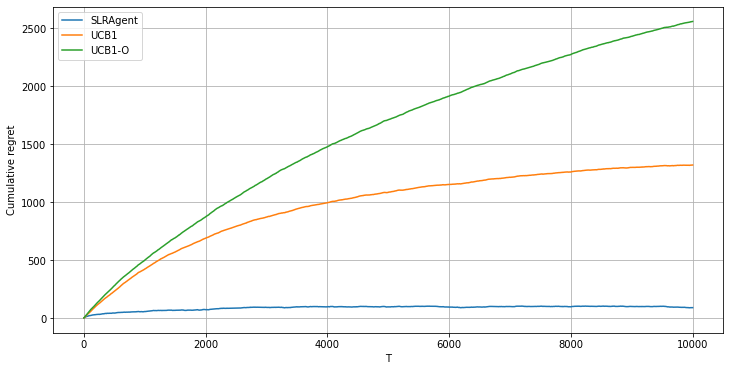

In [112]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

In [113]:
agents = ['UCB1-O', 'SLRAgent']
relative_regrets = {}

ucb1_regret_cumsum = np.mean(agent_to_regret['UCB1'], axis=0)
for agent_name in agents:
    regret_cumsum = np.mean(agent_to_regret[agent_name], axis=0)
    relative_regret = regret_cumsum/ucb1_regret_cumsum

    # removing the first observations for numerical stability
    relative_regret = relative_regret[100:]
    
    relative_regrets[agent_name] = relative_regret

UCB1-O
SLRAgent


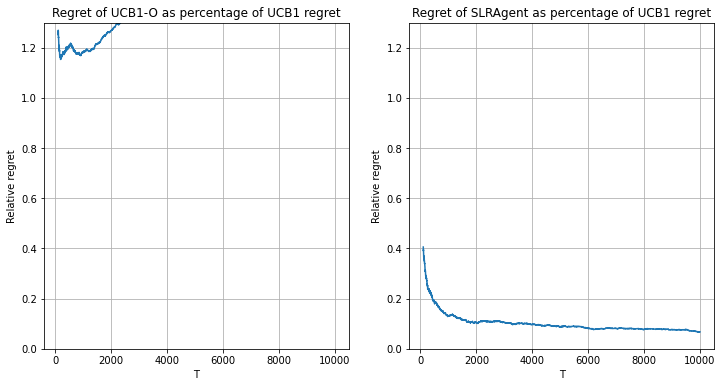

In [114]:
fig,axs=plt.subplots(figsize=(12, 6))


for i, agent_name in enumerate(agents):
    plt.subplot(1, 2, i+1)
    ts = np.arange(100, T)
    print(agent_name)
    plt.plot(ts, relative_regrets[agent_name])
    plt.xlabel('T')
    plt.ylabel('Relative regret')
    plt.title(f'Regret of {agent_name} as percentage of UCB1 regret')
    plt.grid()
    plt.ylim(0, 1.3);